In [28]:
import pandas
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook

In [3]:
table = pandas.read_csv('./sds.csv')

In [4]:
table['age'] = table['age'].astype('int')

In [5]:
b0 = table[table.feature_X == 'B0']

In [7]:
b0

,feature_X,feature_X_num,age,cpi_sum,unique_users,payers_cumsum,revenue_cumsum,rpi,roas,c2p,cpa,cpi,arppu
0,B0,0,1,4636846.09,471283,3325.0,3.664567e+04,0.077757,0.007903,0.007055,1394.540177,9.838772,11.021255
1,B0,0,2,4636846.09,471283,6712.0,9.176032e+04,0.194703,0.019789,0.014242,690.829274,9.838772,13.671085
2,B0,0,3,4636846.09,471283,8801.0,1.394611e+05,0.295918,0.030077,0.018675,526.854459,9.838772,15.846053
3,B0,0,4,4636846.09,471283,10280.0,1.829081e+05,0.388107,0.039447,0.021813,451.055067,9.838772,17.792614
4,B0,0,5,4636846.09,471283,11467.0,2.219439e+05,0.470936,0.047865,0.024331,404.364358,9.838772,19.355014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,B0,0,139,4636846.09,471283,24996.0,2.946850e+06,6.252825,0.635529,0.053038,185.503524,9.838772,117.892861
139,B0,0,140,4636846.09,471283,24998.0,2.948319e+06,6.255941,0.635846,0.053042,185.488683,9.838772,117.942183
140,B0,0,141,4636846.09,471283,24999.0,2.949356e+06,6.258143,0.636070,0.053045,185.481263,9.838772,117.978976
141,B0,0,142,4636846.09,471283,25001.0,2.949845e+06,6.259180,0.636175,0.053049,185.466425,9.838772,117.989083


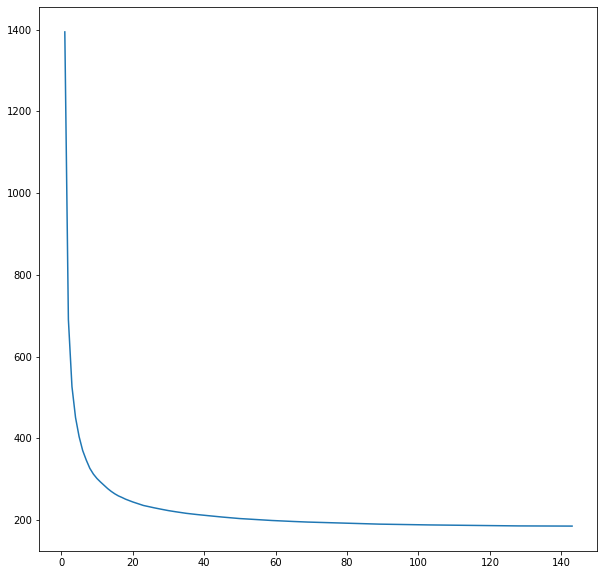

In [8]:
x = b0.age.to_list()
y = b0.cpa.to_list()
plt.figure(figsize=(10, 10))
plt.plot(x, y);

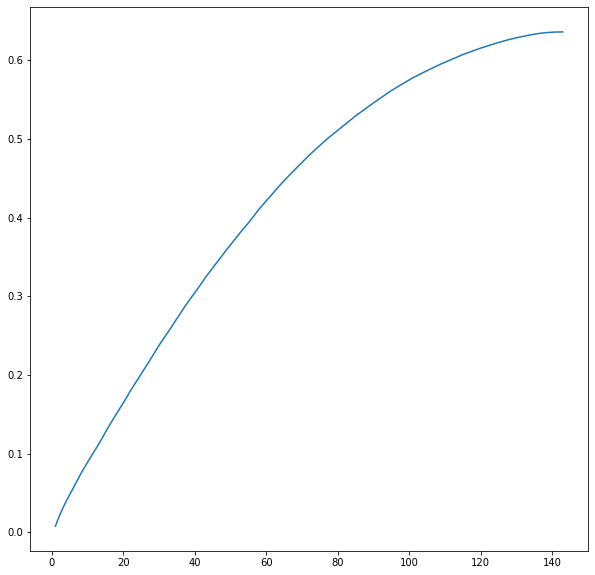

In [9]:
x = b0.age.to_list()
y = b0.roas.to_list()
plt.figure(figsize=(10, 10))
plt.plot(x, y);

Вам необходимо, используя данные, постараться ответить на вопросы:
- какие показатели RoAS[n], CPA[n] (n = 1, 3, 7, 30 дней) нужны для того, чтобы трафик окупился на 100% на 365-ый день (RoAS[365] = 1) в каждом из сегментов B0 … B12?

In [131]:
data = table[['rpi', 'roas', 'cpi', 'c2p', 'cpi', 'cpa']].to_numpy()

In [152]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 400),
    torch.nn.Sigmoid(),
    torch.nn.Linear(400, 1)
        )
data = torch.tensor(table[['age', 'cpa']].astype(np.float32).to_numpy())
target = torch.tensor(table['roas'].astype(np.float32).to_numpy())

In [153]:
model(data)

tensor([[-0.2817],
        [-0.2978],
        [-0.3076],
        ...,
        [-0.4498],
        [-0.4408],
        [-0.4168]], grad_fn=<AddmmBackward0>)

In [158]:
def train(table, column, draw=True, epoch=200):  
    data = torch.tensor(table[['age']].astype(np.float32).to_numpy())
    target = torch.tensor(table[column].astype(np.float32).to_numpy())
    dataloader = list(zip(data, target))
    train_data, test_data = train_test_split(dataloader, test_size=0.3, shuffle=False)
    n_epochs = epoch
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    train_losses = []
    val_losses = []

    model = torch.nn.Sequential(
        torch.nn.Linear(1, 400),
        torch.nn.Sigmoid(),
        torch.nn.Linear(400, 1)
        )
    
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = torch.nn.functional.mse_loss    
        
    for epoch in tqdm_notebook(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for x, y in train_data:
            optimizer.zero_grad()
    #         reconstructed = model(X_batch.to(device))
            predict = model(x.to(device))
            loss = loss_fn(predict, y.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for x, y in test_data:
                predict = model(x.to(device))
                loss = loss_fn(predict, y.to(device))
                val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
    if draw:
        x = torch.tensor(np.linspace(0, 150), dtype=torch.float32).reshape(50, 1)
        model.eval()
        with torch.no_grad():
            y = np.array([model.cpu()(i) for i in x])
        x.reshape(50)    
        fig, ax = plt.subplots(2, 2, figsize=(16, 16))
        ax[0][0].plot(train_losses, label='train_losses')
        ax[0][0].set_title('train_losses')
        ax[0][1].plot(val_losses, label='val_losses')
        ax[0][1].set_title('val_losses')
        ax[1][0].plot(data, target, label='original')
        ax[1][0].set_title('original')
        ax[1][1].plot(x, y, label='predict')
        ax[1][1].set_title('predict')
        plt.legend()
        plt.show()
    return model

In [172]:
def predict_result(table, model):
    a1 = torch.tensor([1], dtype=torch.float32)
    a3 = torch.tensor([3], dtype=torch.float32)
    a7 = torch.tensor([7], dtype=torch.float32)
    a30 = torch.tensor([30], dtype=torch.float32)
    a365 = torch.tensor([365], dtype=torch.float32)
    model.eval()
    model.cpu()
    with torch.no_grad():
#         print(model(a1), model(a3), model(a7), model(a30), model(a365))
        print('a1: ', float(model(a1)), '\n')
        print('a3: ', float(model(a3)), '\n')
        print('a7: ', float(model(a7)), '\n')
        print('a30: ', float(model(a30)), '\n')
        print('a365: ', float(model(a365)), '\n')
    return model(a1), model(a3), model(a7), model(a30), model(a365)

In [173]:
def check_segment(number, column, draw=False, epoch=200):
    b = table[table.feature_X == f'B{number}']
    model_b = train(b, column=column, draw=draw, epoch=epoch)
    return predict_result(b, model_b)

/tmp/ipykernel_5180/2030674152.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/2030674152.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/2030674152.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/2030674152.py:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

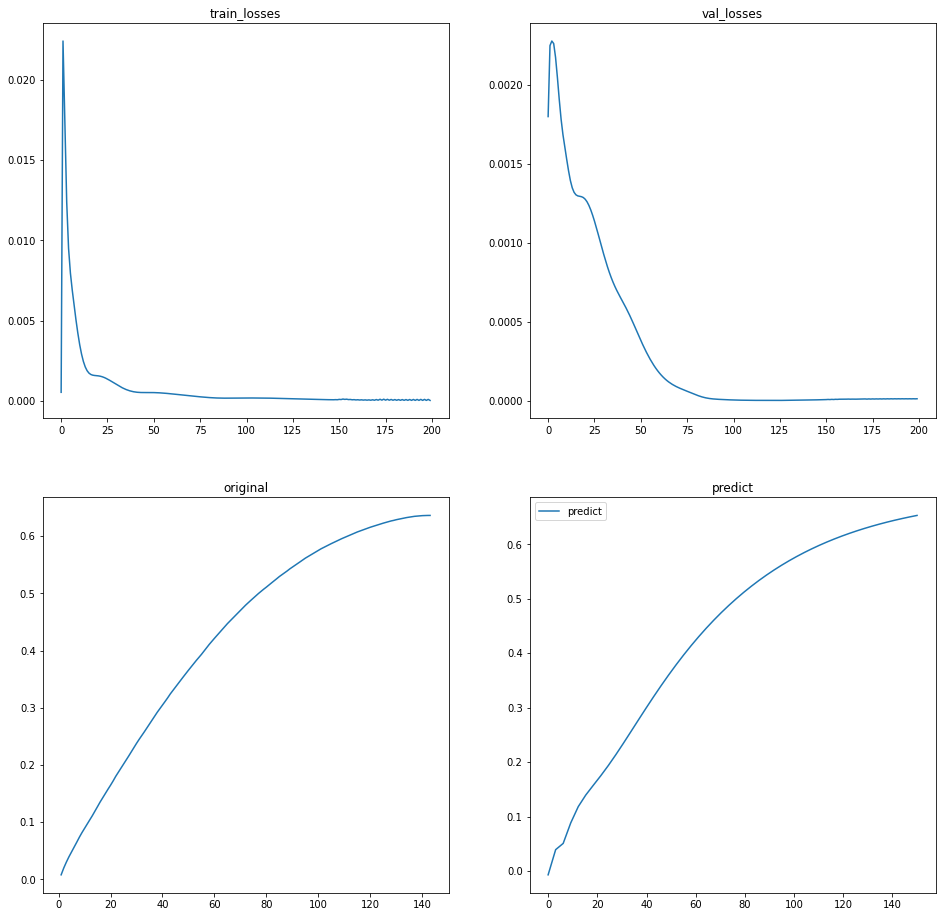

a1:  0.025190945714712143 

a3:  0.03946444019675255 

a7:  0.06119295582175255 

a30:  0.23057249188423157 

a365:  0.6950477957725525 



In [161]:
check_segment(0, column='roas', draw=True)

/tmp/ipykernel_5180/2030674152.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/90 [00:00<?, ?it/s]

/tmp/ipykernel_5180/2030674152.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/2030674152.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/2030674152.py:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

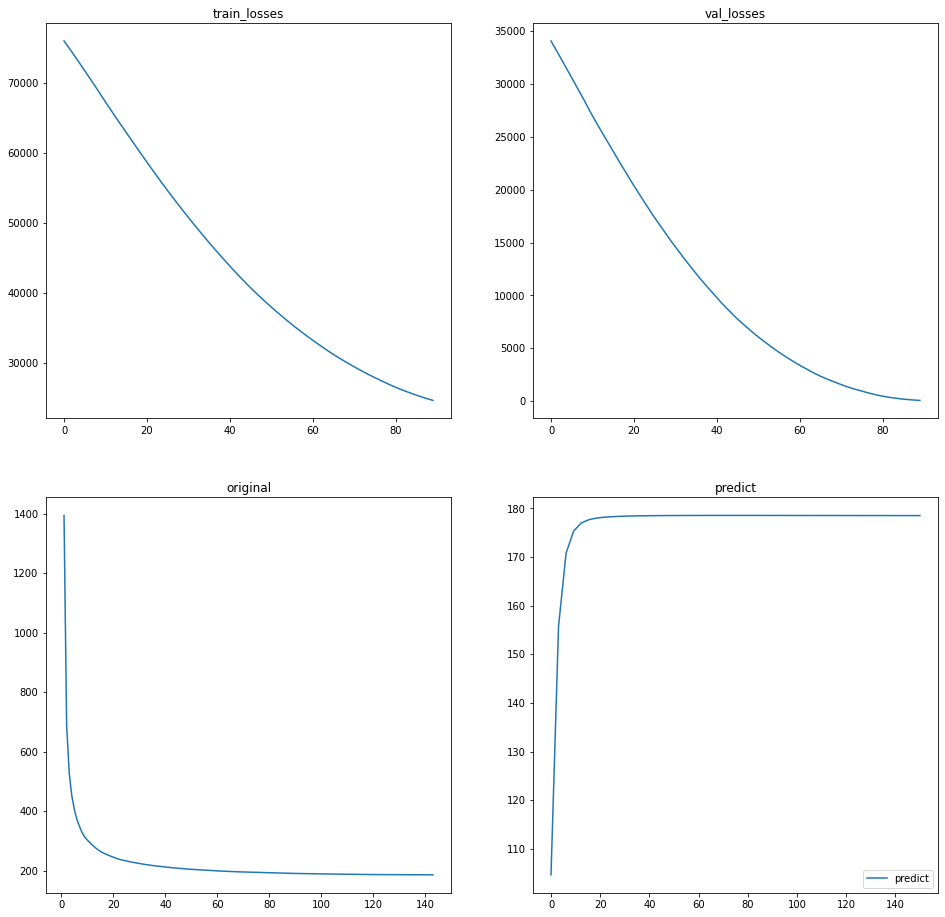

a1:  126.71432495117188 

a3:  155.20013427734375 

a7:  172.6086883544922 

a30:  178.3936309814453 

a365:  178.47109985351562 



In [162]:
check_segment(0, column='cpa', draw=True, epoch=90)

In [179]:
def requirements_value(a1, a3, a7, a30, a365):
    koef = 1/float(a365)
    a1, a3, a7, a30 = float(a1), float(a3), float(a7), float(a30)
    print('a1 can be', a1 * koef, 'real: ', a1)
    print('a1 can be', a3 * koef, 'real: ', a3)
    print('a1 can be', a7 * koef, 'real: ', a7)
    print('a1 can be', a30 * koef, 'real: ', a30)
    

/tmp/ipykernel_5180/2030674152.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/2030674152.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/2030674152.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/2030674152.py:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

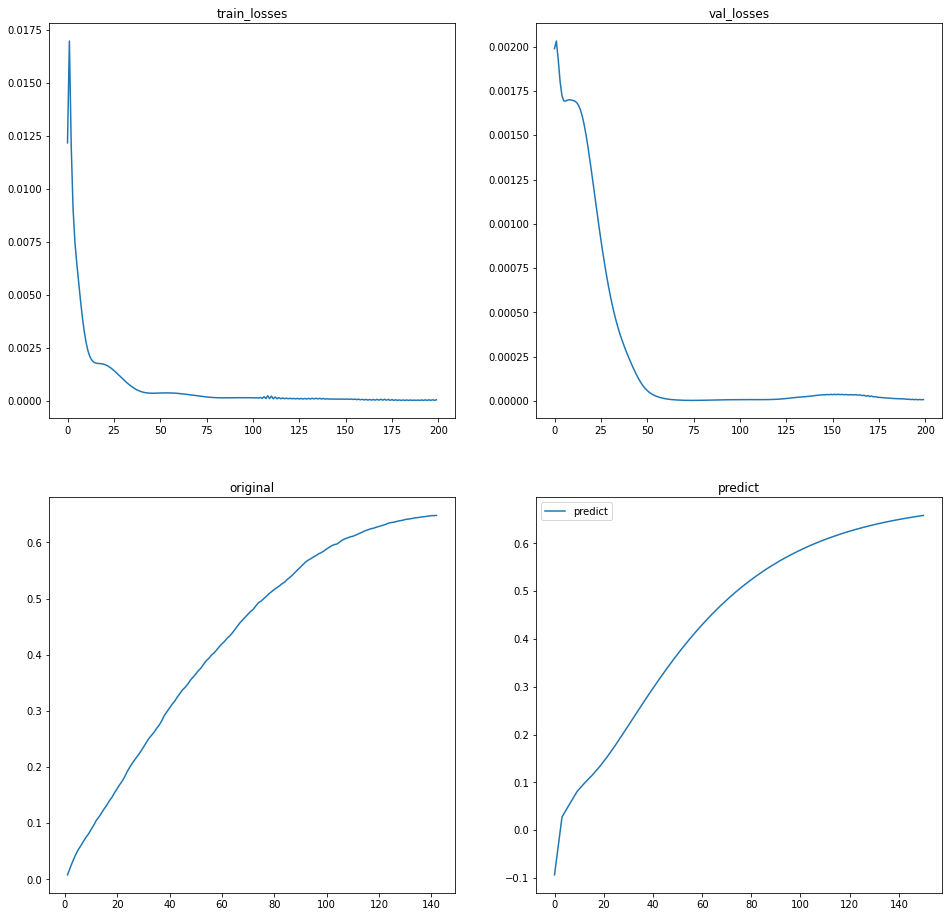

a1:  -0.015465190634131432 

a3:  0.027294093742966652 

a7:  0.06313397735357285 

a30:  0.2185554951429367 

a365:  0.691787838935852 



In [174]:
a1, a3, a7, a30, a365 = check_segment(1, column='roas', draw=True)

In [180]:
requirements_value(a1, a3, a7, a30, a365)

a1 can be -0.022355395344793687 real:  -0.015465190634131432
a1 can be 0.039454428376410895 real:  0.027294093742966652
a1 can be 0.09126205145596253 real:  0.06313397735357285
a1 can be 0.3159285012571649 real:  0.2185554951429367


In [171]:
a1, a3, a7, a30, a365

(tensor([1.]), tensor([3.]), tensor([7.]), tensor([30.]), tensor([365.]))

То есть при таком раскладе мы не окупимся(

Теперь взглянем на график

/tmp/ipykernel_5180/2308668672.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.array([model_b0.cpu()(i) for i in x])
/tmp/ipykernel_5180/2308668672.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array([model_b0.cpu()(i) for i in x])


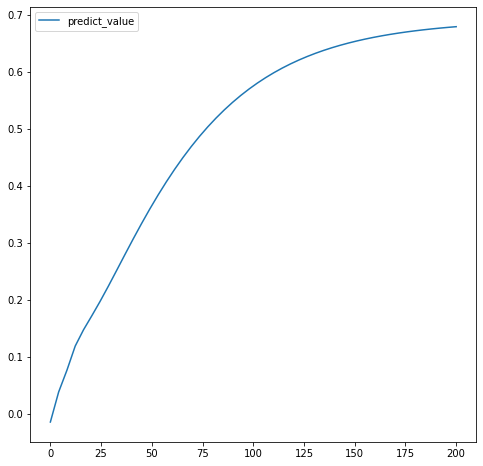

In [70]:
x = torch.tensor(np.linspace(0, 200), dtype=torch.float32).reshape(50, 1)
model_b0.eval()
with torch.no_grad():
    y = np.array([model_b0.cpu()(i) for i in x])
x.reshape(50)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='predict_value')
plt.legend()
plt.show()

Сложно сказать насколько он правильный т.к. нигде дданных больше 140 дня нет, но если бы я от руки рисовал было бы что то похожее, так что жаловаться не буду на нейронку

Эти величины отражают необходимые показатели и также дают понять будет ли вообще достигнут необходимый показатель 

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

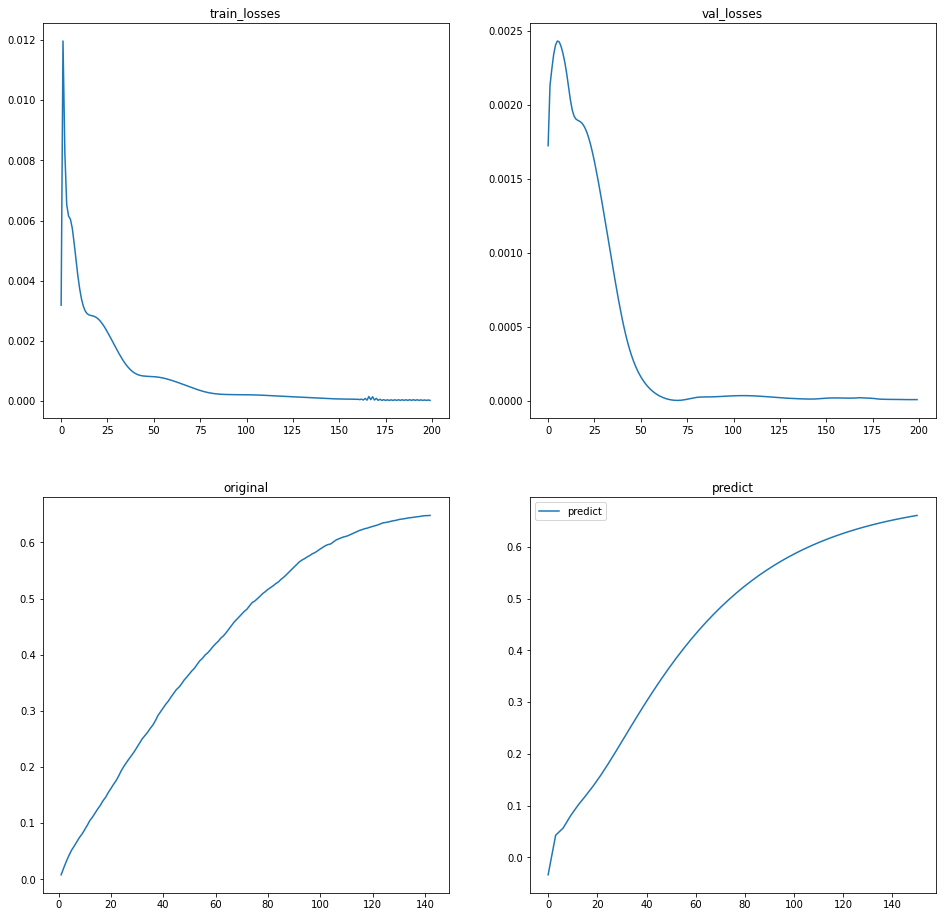

In [71]:
b1 = table[table.feature_X == 'B1']
model_b1 = train(b1)

In [84]:
predict_result(model_b1, b1)

a1:  0.008713509887456894 

a3:  0.0425695963203907 

a7:  0.06364008784294128 

a30:  0.2240690439939499 

a365:  0.7003204822540283 



/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

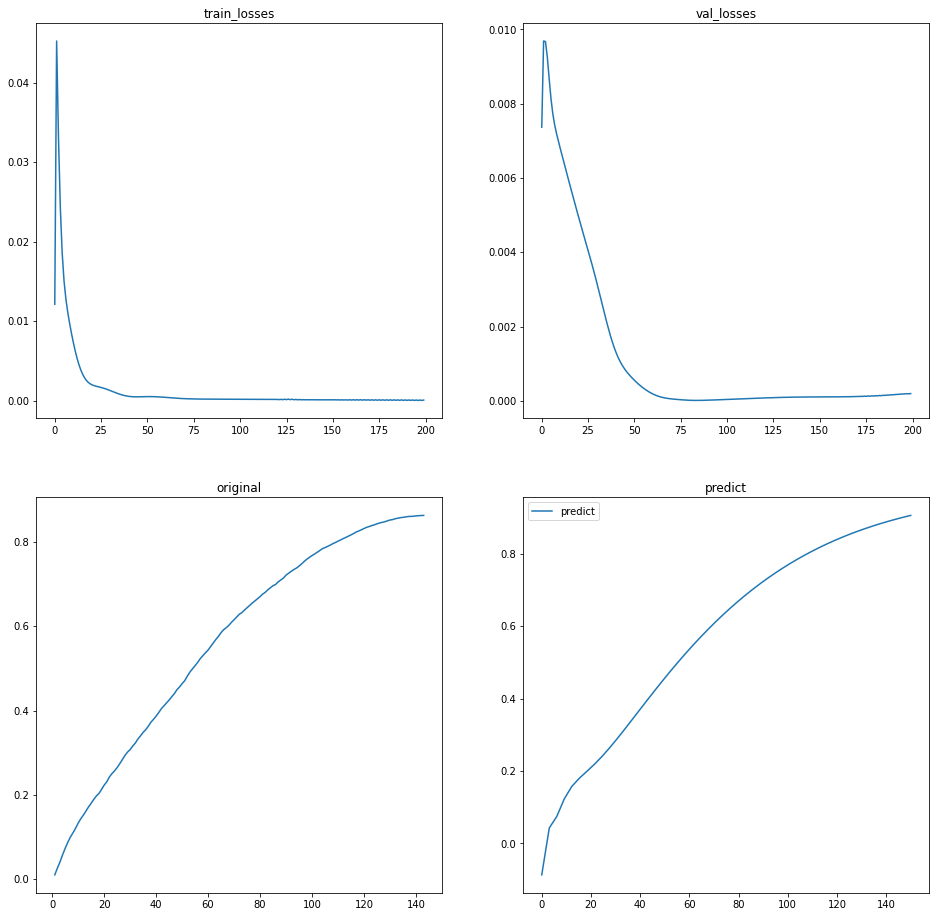

a1:  -0.013960336335003376 

a3:  0.04224161431193352 

a7:  0.08911659568548203 

a30:  0.28363364934921265 

a365:  0.9846270680427551 



In [87]:
check_segment(2)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

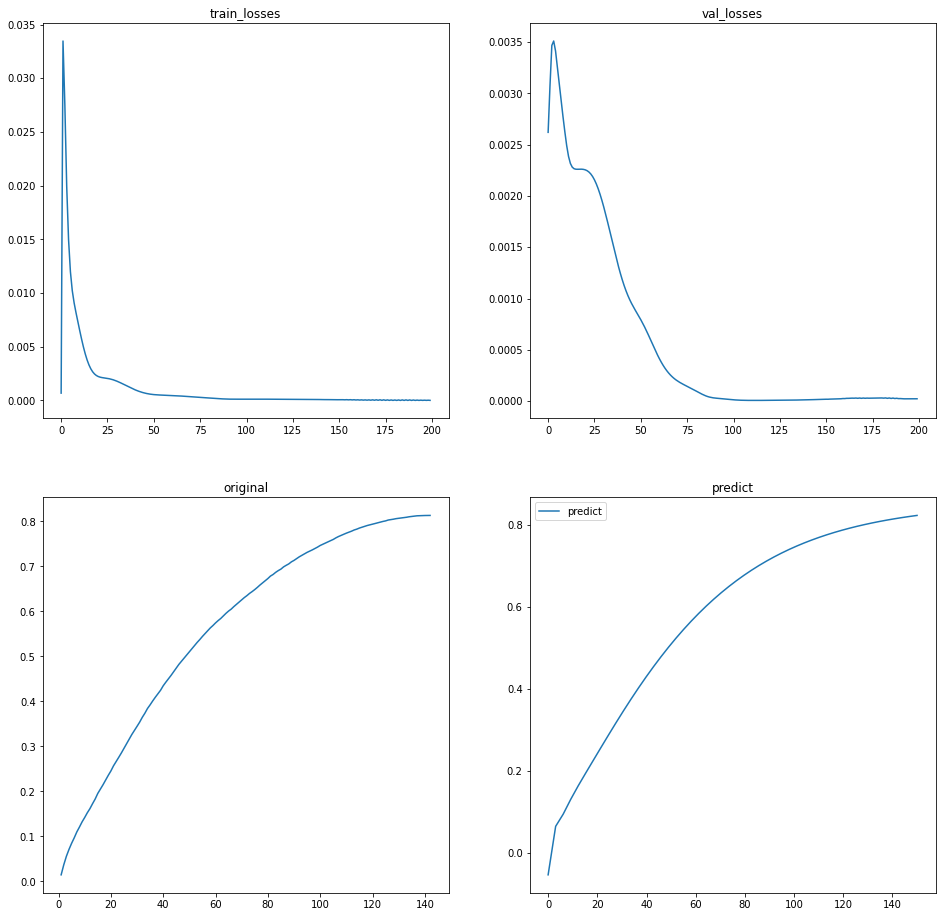

a1:  0.01552758738398552 

a3:  0.06513245403766632 

a7:  0.10572145879268646 

a30:  0.3408927917480469 

a365:  0.8562267422676086 



In [89]:
check_segment(3)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

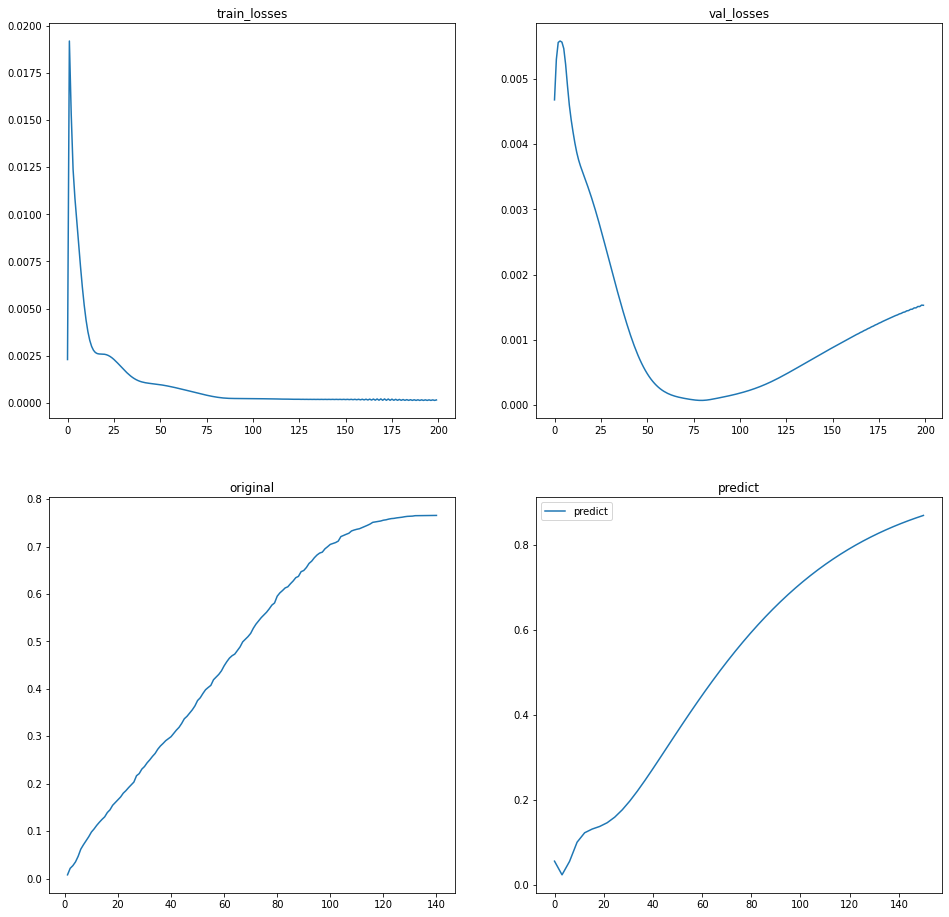

a1:  0.04298122227191925 

a3:  0.023662133142352104 

a7:  0.06997786462306976 

a30:  0.19263722002506256 

a365:  0.956697940826416 



In [90]:
check_segment(4)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

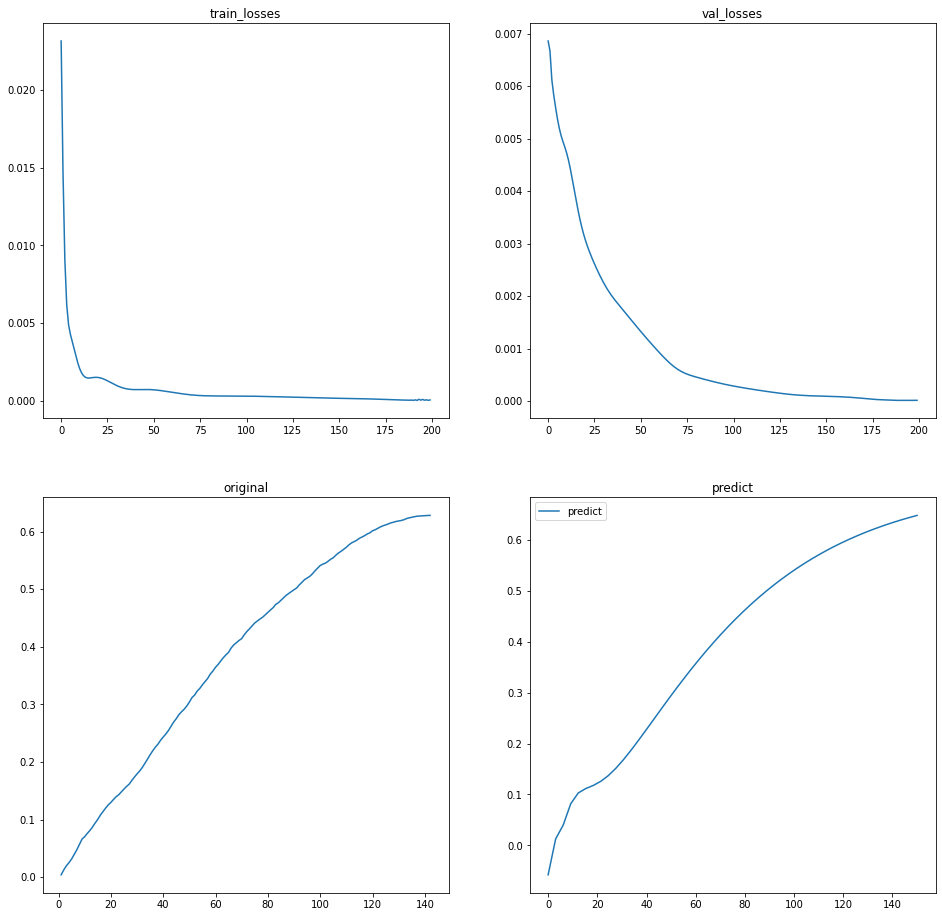

a1:  -0.008152008056640625 

a3:  0.012763872742652893 

a7:  0.05334356427192688 

a30:  0.1647210419178009 

a365:  0.7113028764724731 



In [91]:
check_segment(5)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

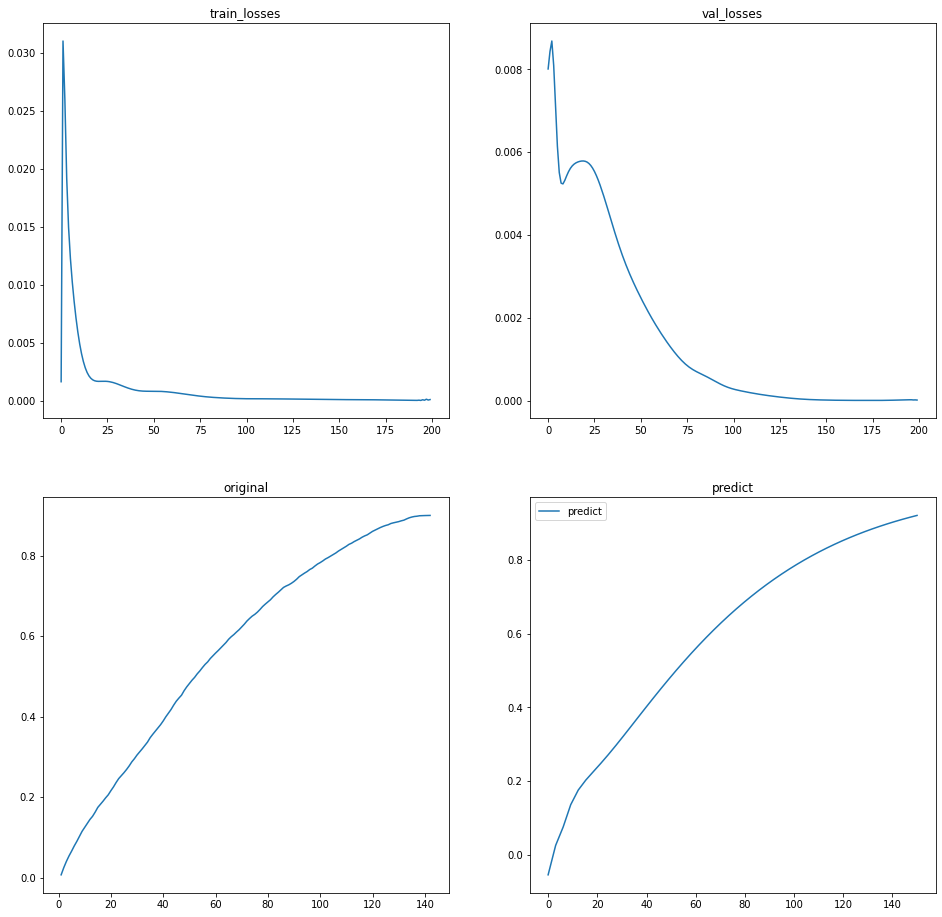

a1:  -0.011638373136520386 

a3:  0.025954075157642365 

a7:  0.09529034048318863 

a30:  0.31739935278892517 

a365:  1.0046848058700562 



In [92]:
check_segment(6)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

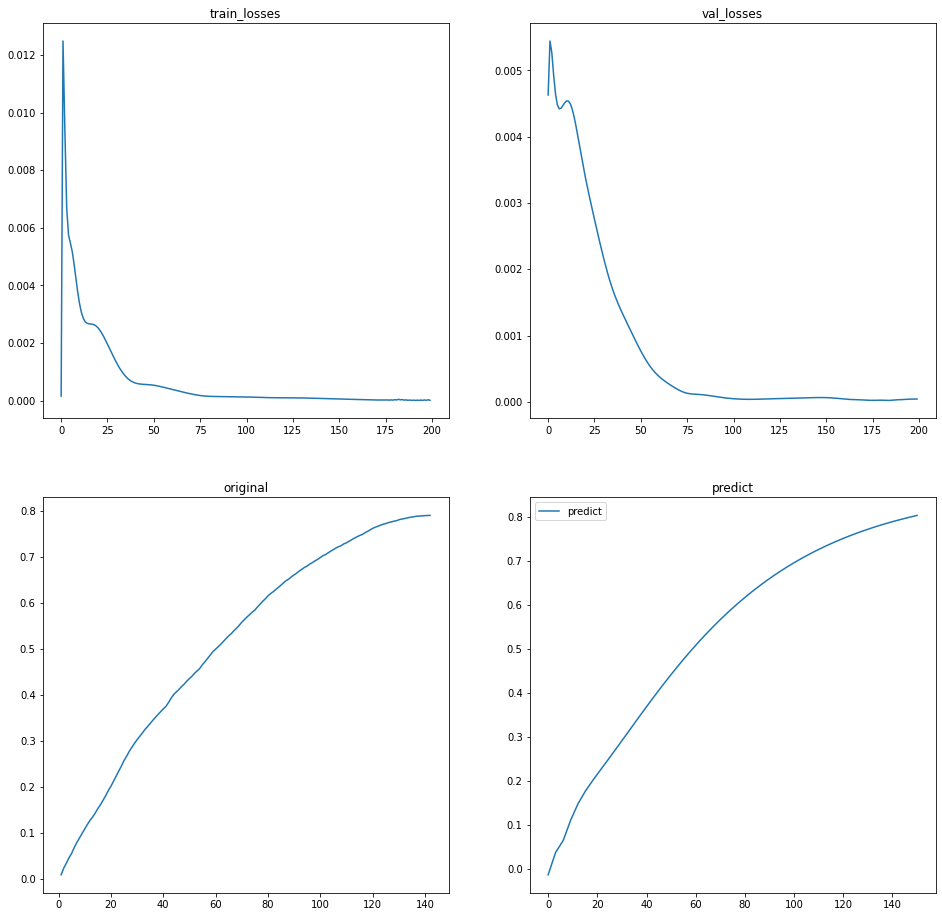

a1:  0.020898934453725815 

a3:  0.03757060691714287 

a7:  0.0778055340051651 

a30:  0.2913745045661926 

a365:  0.8724895715713501 



In [93]:
check_segment(7)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

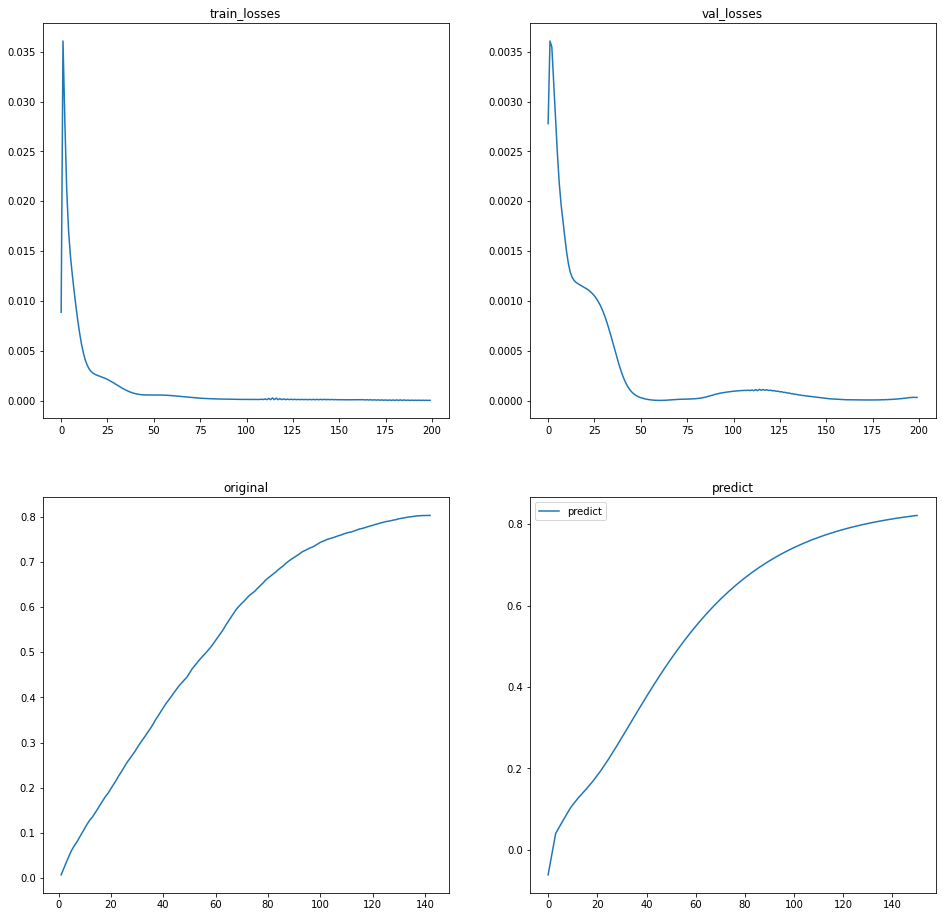

a1:  -0.010436020791530609 

a3:  0.03966215252876282 

a7:  0.08278991281986237 

a30:  0.27615731954574585 

a365:  0.849156379699707 



In [94]:
check_segment(8)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

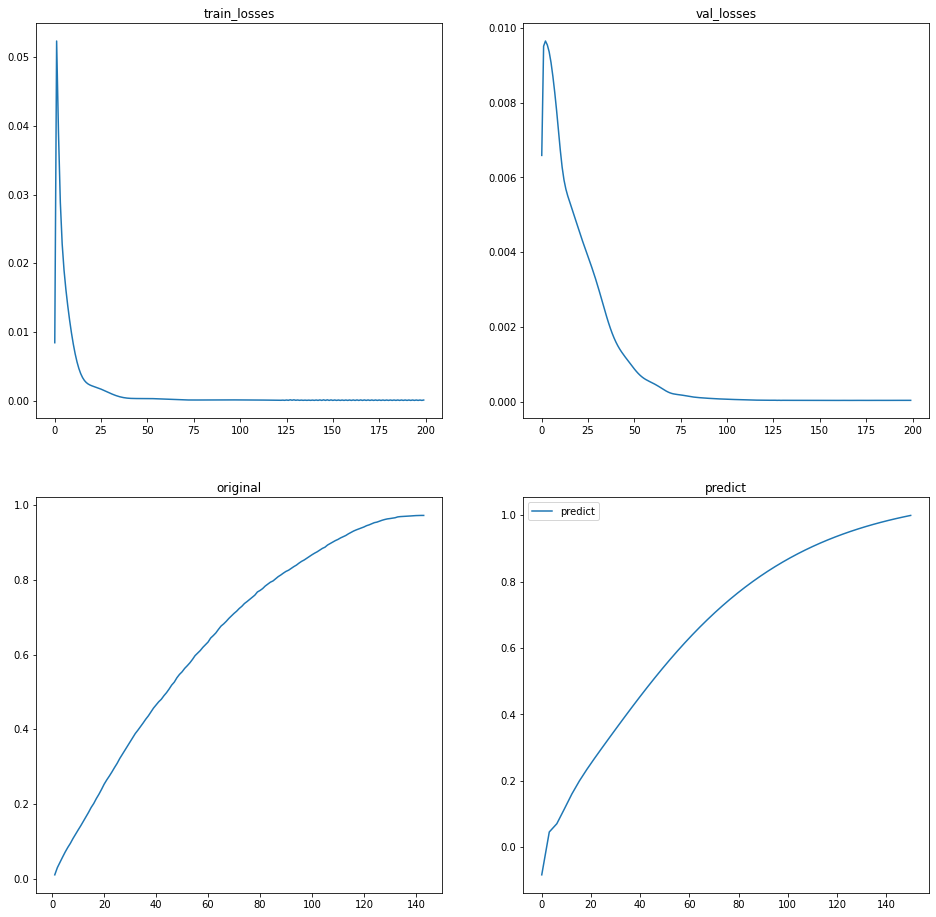

a1:  -0.012477520853281021 

a3:  0.04494056478142738 

a7:  0.08182497322559357 

a30:  0.3548915386199951 

a365:  1.069006085395813 



In [95]:
check_segment(9)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

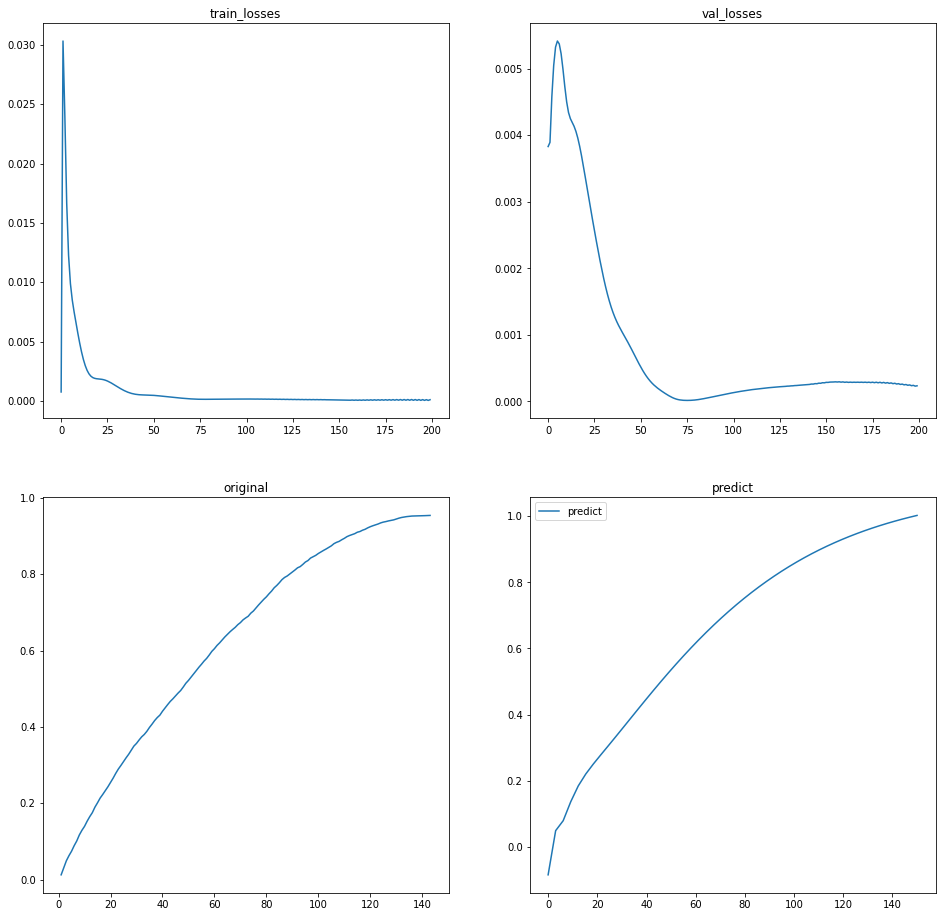

a1:  -0.00879266019910574 

a3:  0.048430100083351135 

a7:  0.0948382318019867 

a30:  0.35602831840515137 

a365:  1.0896916389465332 



In [96]:
check_segment(10)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

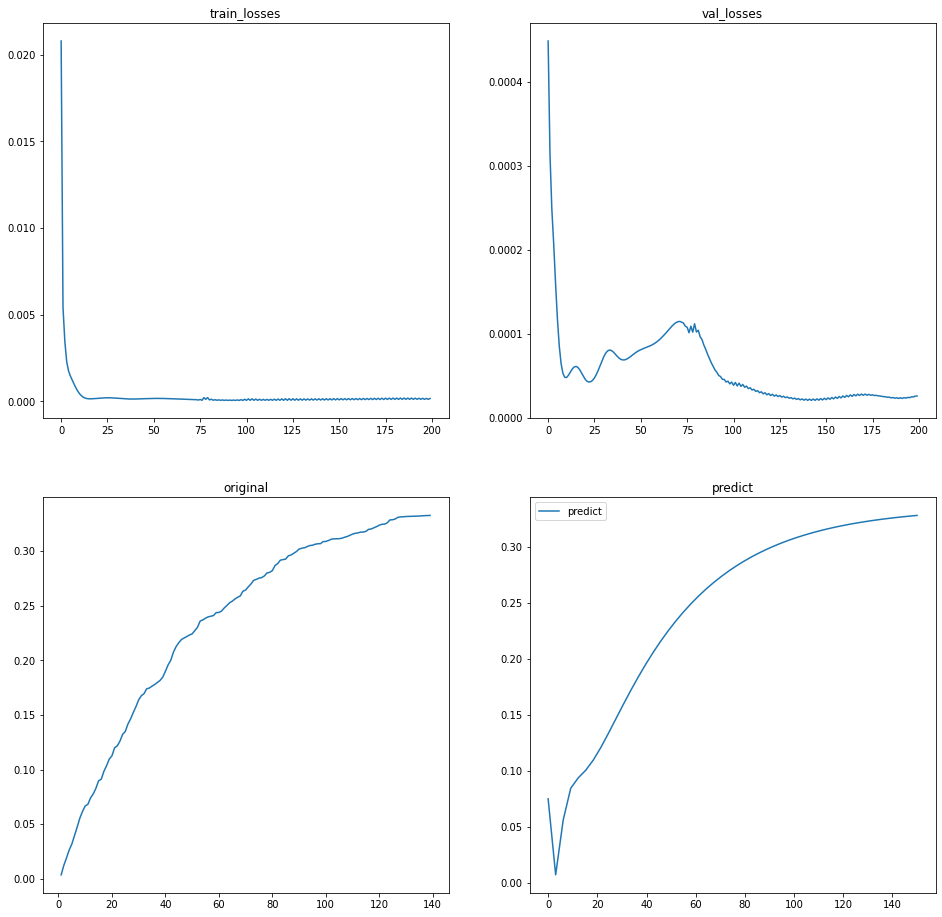

a1:  0.03333450108766556 

a3:  0.0068947747349739075 

a7:  0.06766995787620544 

a30:  0.15698331594467163 

a365:  0.33573830127716064 



In [97]:
check_segment(11)

/tmp/ipykernel_5180/3564792086.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_5180/3564792086.py:30: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:42: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(predict, y.to(device))
/tmp/ipykernel_5180/3564792086.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an em

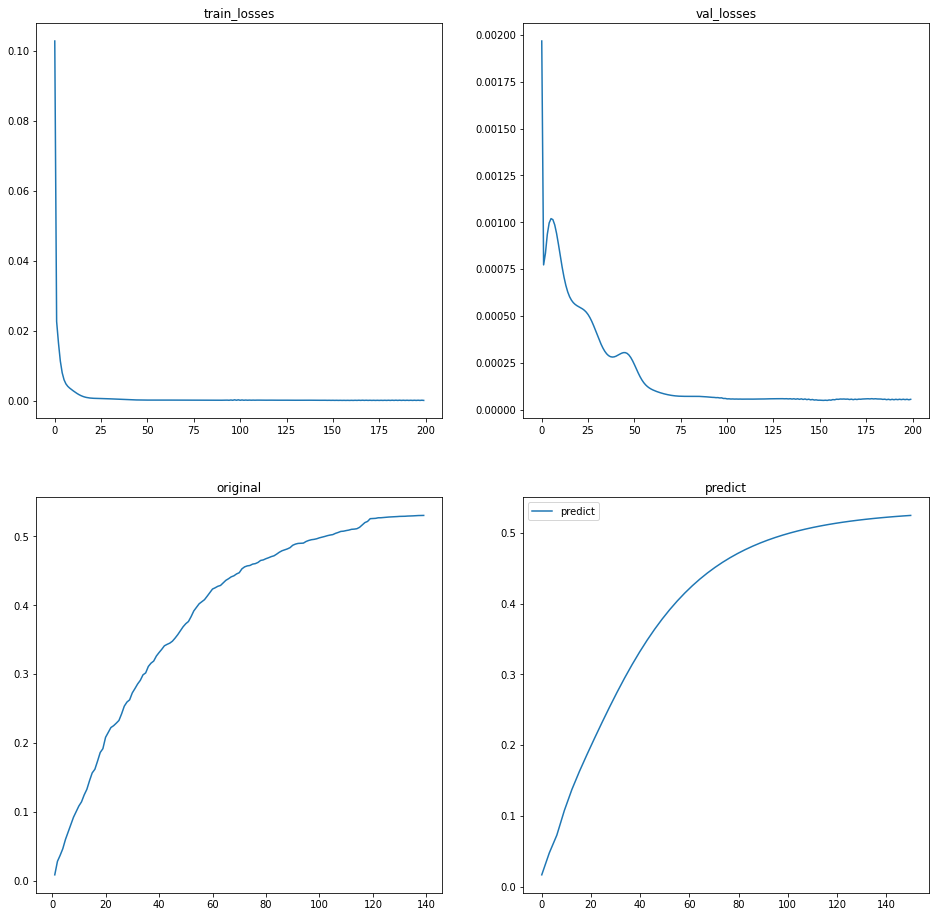

a1:  0.03442845493555069 

a3:  0.0476401224732399 

a7:  0.08313918858766556 

a30:  0.27061015367507935 

a365:  0.5333961844444275 



In [98]:
check_segment(12)